In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ab_data = pd.read_csv('data/ab_data.csv')

In [3]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

In [6]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    290482 non-null  int64         
 1   timestamp  290482 non-null  datetime64[ns]
 2   group      290482 non-null  object        
 3   converted  290482 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 8.9+ MB


In [7]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [8]:
daily_data['conversion'] = round(daily_data['converted']/daily_data['users_count']*100, 2)
daily_data.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.52
1,2017-01-02,B,2848,339,11.90
2,2017-01-03,A,6584,749,11.38
3,2017-01-03,B,6620,754,11.39
4,2017-01-04,A,6573,797,12.13


In [9]:
daily_data[daily_data['timestamp']=='2017-01-05']

,timestamp,group,users_count,converted,conversion
6,2017-01-05,A,6419,791,12.32
7,2017-01-05,B,6509,743,11.41


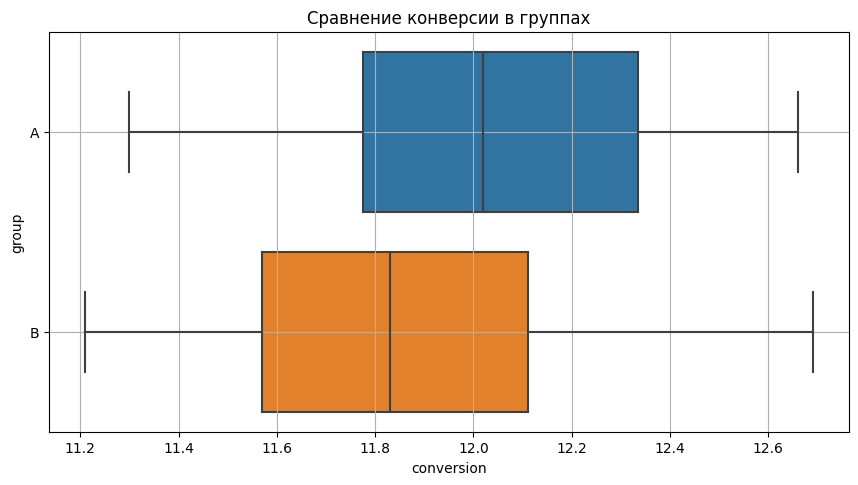

In [10]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax)
ax.set_title('Сравнение конверсии в группах')
ax.grid()

In [11]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(['mean','median'])
conversion_piv

,mean,median
group,,
A,12.033478,12.02
B,11.872174,11.83


<Axes: xlabel='timestamp', ylabel='conversion'>

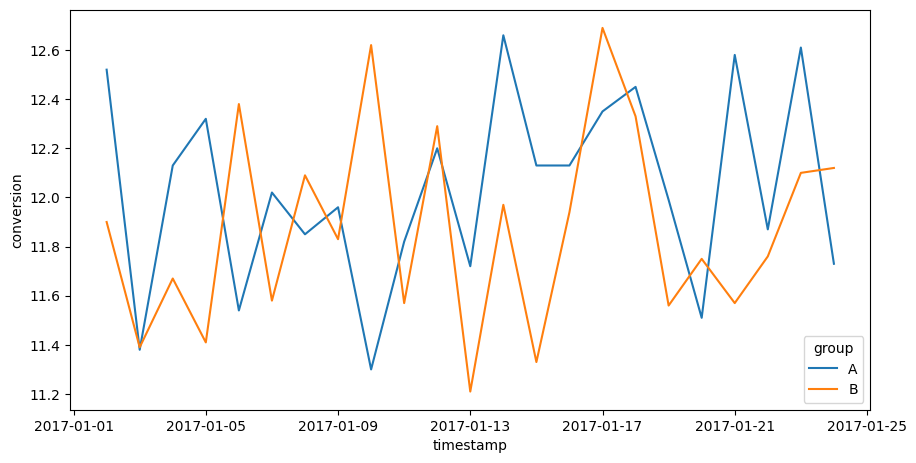

In [12]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])
sns.lineplot(data=daily_data, x='timestamp', y='conversion', hue='group', ax=ax)

In [13]:
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count']*100
daily_data.head()

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.52,2851,357,12.521922
1,2017-01-02,B,2848,339,11.90,2848,339,11.903090
2,2017-01-03,A,6584,749,11.38,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.39,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.13,16008,1903,11.887806


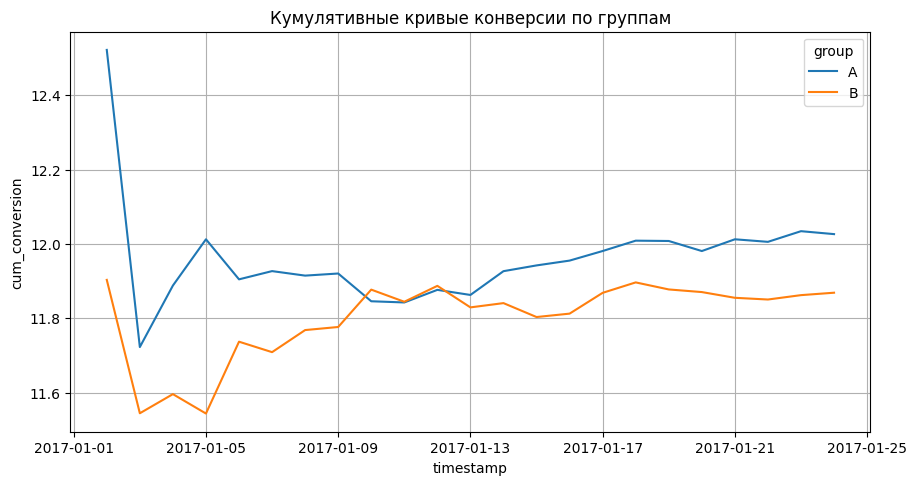

In [14]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])
sns.lineplot(data=daily_data, x='timestamp', y='cum_conversion', hue='group', ax = ax)
ax.set_title('Кумулятивные кривые конверсии по группам')
ax.grid(True)

In [15]:
converted_piv = ab_data.groupby('group')['converted'].agg(['sum','count'])
converted_piv

,sum,count
group,,
A,17467,145241
B,17238,145241


In [16]:
from statsmodels.stats.proportion import proportions_ztest
H0 = 'Конверсии в группах А и В равны'
H1 = 'Конверсия в группе А выше, чем в группе В'
alpha = 0.05
_,p_value = proportions_ztest(count=converted_piv['sum'], nobs=converted_piv['count'], alternative='larger')
print('p-value', round(p_value, 2))
if p_value<alpha:
    print('Отвергаем нулевую гипотезу. {}'.format(H1))
else:
    print('Принимаем нулевую гипотезу: {}'.format(H0))

p-value 0.1
Принимаем нулевую гипотезу: Конверсии в группах А и В равны


In [20]:
from scipy.stats import norm

In [17]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

In [18]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [21]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


In [22]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [23]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


In [27]:
x=132/189

In [28]:
print(proportions_conf_interval(189, x, 0.9))

(64.35, 75.33)


In [29]:
n = [1000, 1000]
xp = [45/1000, 50/1000]

In [30]:
print(diff_proportions_conf_interval(n, xp))

(-1.36, 2.36)
